# Preprocessing
### Imports

New Python versions sometimes require some extra installations found in the code below

In [1]:
!pip install standard-sunau standard-aifc

In [1]:
#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch.utils.data import DataLoader, Dataset
# Utils
import numpy as np
from numpy import ndarray
import logging
# Base Scripts
from Libraries.Utils import *
from Conf import conf


### Config

In [19]:
remote_kernel: bool = False
training_data_name: str = "training_full_raw"
n_samples: int = 10000
logging_level: int = LIGHT_DEBUG
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Processing

In [18]:
filenames = get_filenames_from_folder(path_to_remote_path(conf["paths"].data_path, remote_kernel), "wav")
data: list = []
remaining_samples: int = n_samples
for i in range(len(filenames)):
    file = load_audio_file(os.path.join(path_to_remote_path(conf["paths"].data_path, remote_kernel), filenames[i]), conf["audio"].sample_rate, True)
    file = split_audiofile(file, conf["audio"].time_frame_s, conf["audio"].sample_rate, conf["audio"].overlap)
    #file = audio_splits_to_spectograms(file, conf["audio"].len_fft, conf["audio"].len_hop)
    data.append(file)
    if file.shape[0] < remaining_samples:
        remaining_samples -= file.shape[0]
    else: break

data: ndarray = np.vstack(data)
data = normalize_filewise(data, -1, 1)
data = dimension_for_VAE(data)[:n_samples]
logger.info(f"Processed data of shape: {data.shape}")

2025-05-31 22:42:36,353 - LIGHT_DEBUG - Got filenames ['Am Bach 2024.wav', 'Cutting Mixes mix.wav', 'DA2407_ADO.wav'] from ../Data
2025-05-31 22:43:11,225 - LIGHT_DEBUG - Loaded audio form ../Data\Am Bach 2024.wav of dimensions: (241901628,), sr: 32000
2025-05-31 22:43:11,668 - LIGHT_DEBUG - Split audio to: (2519, 128000)
2025-05-31 22:43:27,900 - LIGHT_DEBUG - Loaded audio form ../Data\Cutting Mixes mix.wav of dimensions: (192650642,), sr: 32000
2025-05-31 22:43:28,205 - LIGHT_DEBUG - Split audio to: (2006, 128000)
2025-05-31 22:43:51,150 - LIGHT_DEBUG - Loaded audio form ../Data\DA2407_ADO.wav of dimensions: (246022144,), sr: 32000
2025-05-31 22:43:51,580 - LIGHT_DEBUG - Split audio to: (2562, 128000)
2025-05-31 22:43:58,931 - LIGHT_DEBUG - Normalized to range: [-1,1]
2025-05-31 22:43:59,666 - INFO - Processed data of shape: (7072, 128000)


### Saving

In [20]:
save_training_data(data, f"{path_to_remote_path(conf["paths"].data_path, remote_kernel)}/{training_data_name}.npy")

2025-05-31 22:44:37,499 - LIGHT_DEBUG - Saved ndarray to:../Data/training_full_raw.npy


### Test Blocks

In [10]:
print(np.min(file[235]), np.max(file[134]))

-1.0 1.0


In [4]:
file = load_audio_file(os.path.join(path_to_remote_path(conf["paths"].data_path, remote_kernel), filenames[0]), conf["audio"].sample_rate, True)
file = split_audiofile(file, conf["audio"].time_frame_s, conf["audio"].sample_rate, conf["audio"].overlap)

2025-05-31 22:15:10,203 - LIGHT_DEBUG - Loaded audio form ../Data\Am Bach 2024.wav of dimensions: (241901628,), sr: 32000
2025-05-31 22:15:10,994 - LIGHT_DEBUG - Split audio to: (2519, 128000)


2025-05-31 22:20:57,163 - LIGHT_DEBUG - Started STFT
2025-05-31 22:20:57,172 - LIGHT_DEBUG - Created spectogram: (245, 161)


(128000,)


2025-05-31 22:20:59,735 - LIGHT_DEBUG - Normalized to range: [-1,1]


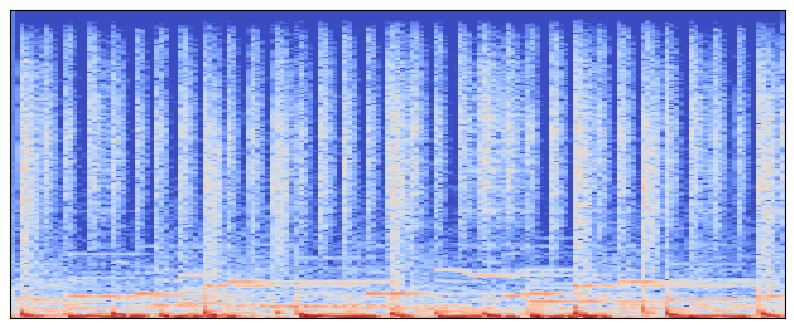

2025-05-31 22:21:00,110 - LIGHT_DEBUG - Started GL
2025-05-31 22:21:00,496 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-05-31 22:21:00,498 - LIGHT_DEBUG - Reconstructed audio: (128000,)
2025-05-31 22:21:00,501 - LIGHT_DEBUG - Normalized to range: [-0.99999,0.99999]
2025-05-31 22:21:00,537 - LIGHT_DEBUG - Saved file to:../Results/low_res.wav


In [17]:
spec = audio_to_spectrogram(file[20], 488, 800, True)
print(file[20].shape)
file = normalize(file, -1, 1)
visualize_spectogram(spec)
save_audio_file(spectrogram_to_audio(spec, 488, 800, conf["audio"].sample_rate), "../Results/low_res.wav", sample_rate=conf["audio"].sample_rate)